In [1]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [17]:
import sys

sys.path.append("../../")

from itertools import cycle

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from functional import seq
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from plotly_resampler.aggregation import MedDiffGapHandler, MinMaxLTTB
from tsflex.processing.logger import get_processor_logs

from code_utils.empatica.scl_processing import (
    gsr_processing_pipeline,
    process_gsr_pipeline,
    scr_processing_pipeline,
)
from code_utils.path_conf import processed_mbrain_path

USE_PNG = True

In [3]:
user = "MBRAIN21-002"
print(
    seq(processed_mbrain_path.glob(f"{user}.empatica*")).map(lambda x: x.name).to_list()
)
user_s = f"{user}.empatica.E4.A02FD1"
date_s = "2022_09_10"

df_eda = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"gsr_{date_s}*"))[0]
).set_index("timestamp")
df_acc = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"acc_{date_s}*"))[0]
).set_index("timestamp")
df_tmp = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"tmp_{date_s}*"))[0]
).set_index("timestamp")

['MBRAIN21-002.empatica.E4.A02FD1', 'MBRAIN21-002.empatica.E4.A0383B']


In [4]:
out = gsr_processing_pipeline.process(df_eda, logging_file_path="gsr_processing.log")
pl = get_processor_logs("gsr_processing.log").drop(columns=["log_time"])
pl = pl.assign(p_dur=(100 * pl.duration / pl.duration.sum()).round(2))
display(pl)
print(
    round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning: Logging file (gsr_processing.log) already exists. This file will be overwritten!
  warnings.warn(


,function,series_names,duration,p_dur
0,low_pass_filter,"(EDA,)",0 days 00:00:00.019939661,22.17
1,slope_sqi,"(EDA_lf_1Hz,)",0 days 00:00:00.001516342,1.69
2,normalized_noise,"(EDA, EDA_lf_1Hz)",0 days 00:00:00.000887394,0.99
3,<lambda>,"(noise,)",0 days 00:00:00.005047560,5.61
4,threshold_sqi,"(noise_mean_2s,)",0 days 00:00:00.001140118,1.27
5,lost_sqi,"(EDA,)",0 days 00:00:00.004860878,5.41
6,delta_sqi,"(EDA, noise_mean_2s)",0 days 00:00:00.017177582,19.10
7,sqi_and,"(EDA_lost_SQI, EDA_delta_SQI, EDA_noise_SQI, E...",0 days 00:00:00.000736237,0.82
8,sqi_smoothen,"(EDA_SQI,)",0 days 00:00:00.004554749,5.06
9,interpolate_sqi,"(EDA, EDA_SQI_smoothend)",0 days 00:00:00.027991533,31.13


0.0085 seconds per hour


In [5]:
out = scr_processing_pipeline.process(out, logging_file_path="scr_processing.log")
pl = get_processor_logs("scr_processing.log").drop(columns=["log_time"])
pl = pl.assign(p_dur=(100 * pl.duration / pl.duration.sum()).round(2))
display(pl)
print(
    round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning: Logging file (scr_processing.log) already exists. This file will be overwritten!
  warnings.warn(


,function,series_names,duration,p_dur
0,tonic_eda,"(EDA_lf_cleaned,)",0 days 00:00:00.045127392,38.25
1,nan_padded_low_pass_filter,"(EDA_lf_cleaned_tonic,)",0 days 00:00:00.004060984,3.44
2,phasic,"(EDA_lf_cleaned, EDA_lf_cleaned_tonic_lf, nois...",0 days 00:00:00.002323389,1.97
3,tonic_eda,"(EDA_Phasic,)",0 days 00:00:00.026661634,22.60
4,nan_padded_low_pass_filter,"(EDA_Phasic_tonic,)",0 days 00:00:00.003686905,3.13
5,<lambda>,"(noise_mean_2s, EDA_lf_cleaned_tonic, EDA_Phas...",0 days 00:00:00.008285999,7.02
6,find_peaks_scipy,"(EDA_Phasic,)",0 days 00:00:00.004989386,4.23
7,dataframe_func: remove_false_positives,"(SCR_RiseTime, SCR_Peaks_scipy, SCR_RecoveryTi...",0 days 00:00:00.022836924,19.36


0.01116 seconds per hour


In [8]:
# print(
#     seq(processed_mbrain_path.glob(f"{user}.empatica*")).map(lambda x: x.name).to_list()
# )
# # user_s = f"MBRAIN21-021.empatica.E4.*"

# user_s = f"MBRAIN21-022.empatica.E4.*"
# df_eda_tot = (
#     pd.concat(
#         [
#             pd.read_parquet(f)
#             for f in processed_mbrain_path.glob(f"{user_s}/gsr_*.parquet")
#         ]
#     )
#     .set_index("timestamp")
#     .sort_index()
# )
# df_eda_tot = df_eda_tot.loc[~df_eda_tot.index.duplicated(keep="first")]

### Visualizing the processed EDA data

In [13]:
user_s = f"MBRAIN21-002.empatica.E4.*"
df_eda_tot = (
    pd.concat(
        [
            pd.read_parquet(f)
            for f in processed_mbrain_path.glob(f"{user_s}/gsr_*.parquet")
        ]
    )
    .set_index("timestamp")
    .sort_index()
)

# NOTE: this is the correct way how to remove duplicates
df_eda_tot = df_eda_tot.loc[~df_eda_tot.index.duplicated(keep="first")]

In [14]:
def plot_gsr_cols(f, df_s, row_idx, palette, add_skip_cols=[]):
    secondary_y_cols = ["EDA_SQI_smoothend"]
    skip_cols = [
        "raw_cleaned",
        "EDA_lf_1Hz",
        "EDA_SQI_smoothend",
        "slope",
        "raw_cleaned_duration_filter",
    ]
    skip_cols += ["EDA_lost_SQI", "EDA_slope_SQI"]
    skip_cols += add_skip_cols
    additional_row_cols = ["slope", "noise", "noise_mean_2s"]
    additional_row_secondary_y_cols = [
        "EDA_lost_SQI",
        "EDA_delta_SQI",
        "EDA_slope_SQI",
        "EDA_noise_SQI",
    ]
    cols = sorted(set(df_s.columns.values).difference(["index"]))
    for col in cols:
        print(f"{col}" + "-" * 30)
        if df_s[col].dtype == "bool":
            df_s[col] = df_s[col].astype("uint8")
        if col in skip_cols:
            continue
        if not len(df_s[col].dropna()):
            print(col, "is all na")
            continue

        if col == "EDA_SQI" or col == "EDA_SQI_tot":
            for sqi_col, col_or, opacity in [
                (df_s[col], "#2ca02c", 0.1),  # good
                ((1 - df_s[col]), "#d62728", 0.2),  # bad
            ]:
                f.add_trace(
                    go.Scattergl(
                        mode="lines",
                        line_width=0,
                        fill="tozeroy",
                        fillcolor=col_or,
                        opacity=opacity,
                        line_shape="vh",
                        showlegend=False,
                    ),
                    hf_x=df_s.index,
                    hf_y=sqi_col,
                    gap_handler=MedDiffGapHandler(fill_value=0),
                    secondary_y=True,
                    row=row_idx,
                    col=1,
                )
        elif col in secondary_y_cols:
            f.add_trace(
                dict(
                    name=col,
                    visible="legendonly",
                    legend=f"legend{row_idx}",
                    makrer_color=next(palette),
                ),
                hf_x=df_s.index,
                hf_y=df_s[col],
                row=row_idx,
                col=1,
                secondary_y=True,
            )
        elif col in additional_row_cols:
            f.add_trace(
                dict(
                    name=col,
                    visible="legendonly",
                    legend=f"legend{row_idx+1}",
                    marker_color=next(palette),
                ),
                hf_x=df_s.index,
                hf_y=df_s[col],
                row=row_idx + 1,
                col=1,
            )
        elif col in additional_row_secondary_y_cols:
            f.add_trace(
                dict(
                    name=col,
                    visible="legendonly",
                    legend=f"legend{row_idx+1}",
                    marker_color=next(palette),
                ),
                hf_x=df_s.index,
                hf_y=df_s[col],
                row=row_idx + 1,
                col=1,
                secondary_y=True,
            )
        else:
            f.add_trace(
                dict(
                    name=col,
                    visible="legendonly",
                    legend=f"legend{row_idx}",
                    marker_color=next(palette),
                ),
                hf_x=df_s[col].index,
                hf_y=df_s[col],
                row=row_idx,
                col=1,
            )

EDA_SQI------------------------------
EDA_SQI_smoothend------------------------------
EDA_delta_SQI------------------------------
EDA_lf_1Hz------------------------------
EDA_lost_SQI------------------------------
EDA_noise_SQI------------------------------
EDA_slope_SQI------------------------------
noise------------------------------
noise_mean_2s------------------------------
raw_cleaned------------------------------
raw_cleaned_duration_filter------------------------------
slope------------------------------


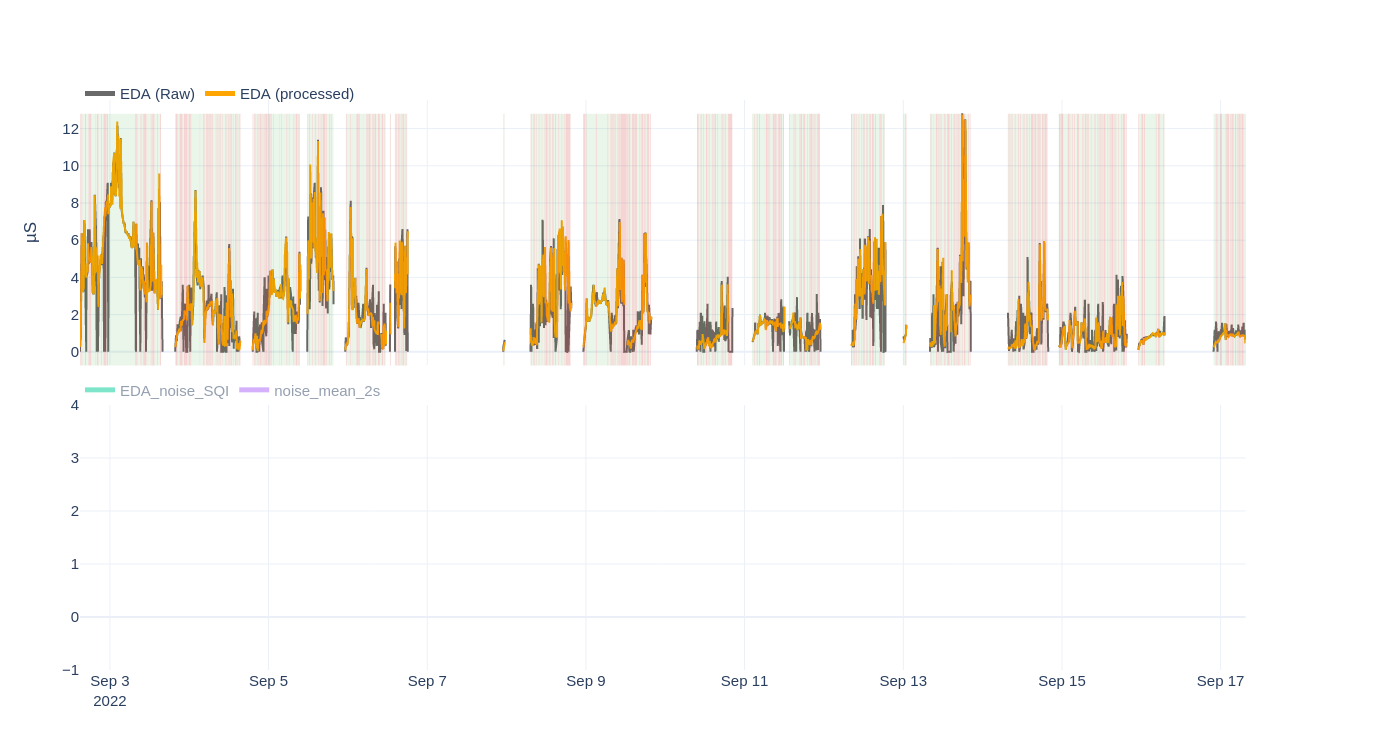

In [19]:
eda_slc = df_eda_tot.first("15D")["EDA"]
out = process_gsr_pipeline(eda_slc, use_scr_pipeline=False, n_jobs=1)
eda_cleaned = out["EDA_lf_cleaned"]
out.drop(columns=["EDA_lf_cleaned"], inplace=True)

fig = FigureResampler(
    make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
        vertical_spacing=0.07,
        # colorway=px.colors.qualitative.Plotly,
    ),
    default_downsampler=MinMaxLTTB(parallel=True),
    show_mean_aggregation_size=False,
    resampled_trace_prefix_suffix=("", ""),
)

# TODO -> get metadata from user and show on the first row

fig.add_trace(
    go.Scatter(name="EDA (Raw)", line_color="dimgrey", legend="legend1"),
    **{"hf_x": eda_slc.index, "hf_y": eda_slc, "row": 1, "col": 1},
)
fig.add_trace(
    go.Scatter(name="EDA (processed)", line_color="orange", legend="legend1"),
    **{"hf_x": eda_cleaned.index, "hf_y": eda_cleaned, "row": 1, "col": 1},
)
plot_gsr_cols(
    fig,
    out,
    row_idx=1,
    add_skip_cols=["EDA_delta_SQI", "noise"],
    palette=cycle(px.colors.qualitative.Plotly[2:]),
)
fig.update_layout(
    template="plotly_white",
    height=750,
    legend1=dict(
        y=1.04,
        bgcolor="rgba(0,0,0,0)",
        orientation="h",
        font_size=15,
        itemsizing="constant",
    ),
    legend2=dict(
        y=0.52,
        bgcolor="rgba(0,0,0,0)",
        orientation="h",
        font_size=15,
        itemsizing="constant",
    ),
    # update the font_size of the axis ticks labels
    font=dict(size=15),
)

# hide the tick-labels of the secondary y-axes
fig.update_yaxes(title_text="µS", row=1, col=1, titlefont_size=17)
fig.update_yaxes(visible=False, showticklabels=False, row=1, col=1, secondary_y=True)
fig.update_yaxes(
    visible=False, showticklabels=False, row=2, col=1, range=[-2, 1.1], secondary_y=True
)
if USE_PNG:
    fig.show(renderer="png", width=1400, height=750)
fig.show_dash(port=8032, mode="inline")